In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D  # noqa
from matplotlib.colors import hsv_to_rgb
from itertools import chain
from yaniv_region_growing import regionGrow

In [4]:
def get_pixel_colors(img_rgb):
    pixel_colors = img_rgb.reshape((np.shape(img_rgb)[0] * np.shape(img_rgb)[1], 3))
    norm = colors.Normalize(vmin=-1.0, vmax=1.0)
    norm.autoscale(pixel_colors)
    return norm(pixel_colors).tolist()
    

def plotRGB(img,pixel_colors):
    r, g, b = cv2.split(img)

    fig = plt.figure()
    axis = fig.add_subplot(1, 1, 1, projection="3d")
    

    axis.scatter(
        r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker="."
    )
    axis.set_xlabel("Red")
    axis.set_ylabel("Green")
    axis.set_zlabel("Blue")
    plt.show()

def plotHSV(img,pixel_colors):
    
    h, s, v = cv2.split(img)

    fig = plt.figure()
    axis = fig.add_subplot(1, 1, 1, projection="3d")
    #pixel_colors = pic.reshape((np.shape(pic)[0] * np.shape(pic)[1], 3))
    axis.scatter(
        h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker="."
    )
    axis.set_xlabel("Hue")
    axis.set_ylabel("Saturation")
    axis.set_zlabel("Value")
    plt.show()
    
def plot_images(imgs,titles,n_rows,n_cols,figsize=(20,20)):
    fig,axes = plt.subplots(n_rows,n_cols,figsize=figsize)
    
    for ax,image,title in zip(axes.flatten(),imgs,titles):
        ax.imshow(image)
        ax.set_title(title)

def mean_smooth_rgb(img,kernel_size):
    def mean_smooth_channel(channel,kernel_size):
        mean_kernel = np.ones(kernel_size,np.float32)/(kernel_size[0]*kernel_size[1])
        return cv2.filter2D(channel,-1,mean_kernel)
    r,g,b = cv2.split(img)
    
    r = mean_smooth_channel(r,kernel_size)
    g = mean_smooth_channel(g,kernel_size)
    b = mean_smooth_channel(b,kernel_size)
    
    return cv2.merge((r,g,b))

def segment_kmeans(img, n_clusters,random_state=0):
    img_normalized = img/255.0
    img_n = img_normalized.reshape(img_normalized.shape[0]*img_normalized.shape[1], img_normalized.shape[2]) # transform to 2d array
    kmeans = KMeans(n_clusters=n_clusters,random_state=random_state).fit(img_n)
    colors_pool = np.array([
        [255,77,0],
        [30,144,255],
        [173,255,47],        
        [255,0,0],
        [0,0,0],
        [255,255,255],
        [255,4,0]
        
    ])
    len_ = colors_pool.shape[0]
    segments_colors = np.array([colors_pool[i%len_] for i in range(len(kmeans.cluster_centers_))])
    img_segmented = segments_colors[kmeans.labels_]
    return img_segmented.reshape(img.shape[0],img.shape[1],img.shape[2])


def pick_color_segment(img_hsv,img_rgb,color="orange"):
    #img_rpf_000102_kmeans_hsv = cv2.cvtColor((kmeans_img*255).astype(np.uint8),cv2.COLOR_RGB2HSV)
    light_orange = (1, 190, 200)
    dark_orange = (18, 255, 255)
    orange_mask = cv2.inRange(img_hsv,light_orange,dark_orange)
    #segment_orange_img = cv2.bitwise_and((kmeans_img*255).astype(np.uint8),(kmeans_img*255).astype(np.uint8),mask=orange_mask)
    segment_orange_img = cv2.bitwise_and(img_rgb,img_rgb,mask=orange_mask)
    return orange_mask,segment_orange_img
    #plot_images([orange_mask,segment_orange_img],["orange_mask","segment_orange_img"],1,2)

def r_theta_to_points(r,theta,point_distance=1000):
    a,b = np.cos(theta), np.sin(theta)
    x0,y0 = a*r, b*r
    x1,y1 = int(x0 + point_distance * (-b)), int(y0 + point_distance*a)
    x2,y2 = int(x0 - point_distance * (-b)), int(y0 - point_distance*a)
    return [(x1,y1),(x2,y2)]

def find_parallel_lines(out_lines,max_theta_thresh = 0.06,min_r_thresh = 100):
    parrallel_lines = [] # will contain indexes from out_lines
    for line_i in range(len(out_lines)):
        for line_j in range(len(out_lines)):
            if line_i == line_j:
                continue
                
            # check for duplicates
            if (line_j,line_i) in parrallel_lines or (line_i,line_j) in parrallel_lines:
                continue
            r_diff = abs(out_lines[line_i][0]-out_lines[line_j][0])
            theta_diff = abs(out_lines[line_i][1]-out_lines[line_j][1])
            if  r_diff > min_r_thresh and theta_diff < max_theta_thresh:
                parrallel_lines.append((line_i,line_j))
    return parrallel_lines

def find_most_parallel_line(out_lines):
    '''
        This problematic because to which feature you give the prefered ordering? 
    '''
    chosen_lines_i = out_lines[0] # will contain indexes from out_lines
    min_r_dif = 999999999999
    min_theta_diff = 9999999999
    for line_i in range(len(out_lines)):
            r_diff = abs(out_lines[line_i][0]-out_lines[chosen_lines_i][0])
            theta_diff = abs(out_lines[line_i][1]-out_lines[chosen_lines_i][1])
            if  r_diff > min_r_dif and theta_diff < min_theta_diff:
                min_r_dif
                
    return parrallel_lines

def draw_hough_lines(img,edge_map,
                     theta_res,rho_res=1,min_votes=150,point_distance=1000,
                    lines_color = (255,0,0)):
    '''
        theta_res = np.pi/180
    '''
    
    lines_map = cv2.HoughLines(edge_map,rho_res,theta_res,min_votes,0,0)
    
    #print(lines_map)
    
    
    outlines  = []
    #for r,theta in lines_map:
    for line in lines_map:
        r,theta = line[0]
        a,b = np.cos(theta), np.sin(theta)
        x0,y0 = a*r, b*r
        x1,y1 = int(x0 + point_distance * (-b)), int(y0 + point_distance*a)
        x2,y2 = int(x0 - point_distance * (-b)), int(y0 - point_distance*a)
        outlines.append([r,theta])
        cv2.line(img,(x1,y1),(x2,y2),lines_color,2)
    return img,outlines


import imageio
import math

def hough_line(img, angle_step=1, lines_are_white=True, value_threshold=5):
    """
    Hough transform for lines
    Input:
    img - 2D binary image with nonzeros representing edges
    angle_step - Spacing between angles to use every n-th angle
                 between -90 and 90 degrees. Default step is 1.
    lines_are_white - boolean indicating whether lines to be detected are white
    value_threshold - Pixel values above or below the value_threshold are edges
    Returns:
    accumulator - 2D array of the hough transform accumulator
    theta - array of angles used in computation, in radians.
    rhos - array of rho values. Max size is 2 times the diagonal
           distance of the input image.
    """
    # Rho and Theta ranges
    thetas = np.deg2rad(np.arange(-90.0, 90.0, angle_step))
    width, height = img.shape
    diag_len = int(round(math.sqrt(width * width + height * height)))
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2)

    # Cache some resuable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint8)
    # (row, col) indexes to edges
    are_edges = img > value_threshold if lines_are_white else img < value_threshold
    y_idxs, x_idxs = np.nonzero(are_edges)

    # Vote in the hough accumulator
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]

        for t_idx in range(num_thetas):
            # Calculate rho. diag_len is added for a positive index
            rho = diag_len + int(round(x * cos_t[t_idx] + y * sin_t[t_idx]))
            accumulator[rho, t_idx] += 1

    return accumulator, thetas, rhos


def show_hough_line(img, accumulator, thetas, rhos, save_path=None):
    plt.imshow(accumulator, aspect='auto',cmap='jet', extent=[np.rad2deg(thetas[-1]), np.rad2deg(thetas[0]), rhos[-1], rhos[0]])
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

def fourier_trans(img_,mask):
    img_fft = np.fft.fft2(img_)
    fshift = np.fft.fftshift(img_fft)
    amplitude = 20 * np.log(np.abs(fshift) + 1)
    fshift*=mask
    amplitude_filtered = 20 * np.log(np.abs(fshift) + 1) 
    return np.abs(np.fft.ifft2(np.fft.ifftshift(fshift))),amplitude,amplitude_filtered #np.abs

def plot_fourier(img,amplitude,mask,amplitude_filtered,img_filtered):
    fig, axes = plt.subplots(2,3, figsize=(20, 10))
    fig.delaxes(axes[1,2])
    for img, ax, title in zip([img, amplitude, mask, amplitude_filtered, np.abs(img_filtered)],
                              chain.from_iterable(axes), 
                              ["img", "Amplitude Spectrum", "Filter", "Filtered Amplitude Spectrum", "img filtered"]):
        ax.imshow(img, cmap='gray')
        
def build_circle_mask(radius,channel):
    circle_mask = np.zeros_like(channel)
    rows,cols = channel.shape
    crow,ccol = rows//2,cols//2

    for i in range(crow-radius, crow+radius):
            for j in range(ccol-radius, ccol + radius):
                if (crow - i) ** 2 + (ccol - j) ** 2 <= radius**2:
                    circle_mask[i,j]=1
    return circle_mask

def build_rectangle_low_pass(height,width,channel):
    zeros = np.zeros_like(channel)
    rows,cols = channel.shape
    crow,ccol = rows//2,cols//2
    zeros[crow-height:crow+height,ccol-width:ccol+width] = 1
    return zeros

def build_rectangle_mask(height,width,channel,crow,ccol):
    ones = np.ones_like(channel)
    print(ccol)
    print(ccol+width)
    ones[crow-height//2:crow+height//2,ccol-width//2:ccol+width//2] = 0
    return ones


def mask_fourier(channels,masks):
    filtered_channels = []
    for channel,mask in zip(channels,masks):
        filtered_channel,amplitude,amplitude_filtered = fourier_trans(channel,mask)
        filtered_channels.append(filtered_channel)
        plot_fourier(channel,amplitude,mask,amplitude_filtered,filtered_channel)
    
    return np.dstack([filtered_channels[0].astype(int), 
                       filtered_channels[1].astype(int), 
                       filtered_channels[2].astype(int)])

# RPf_00068

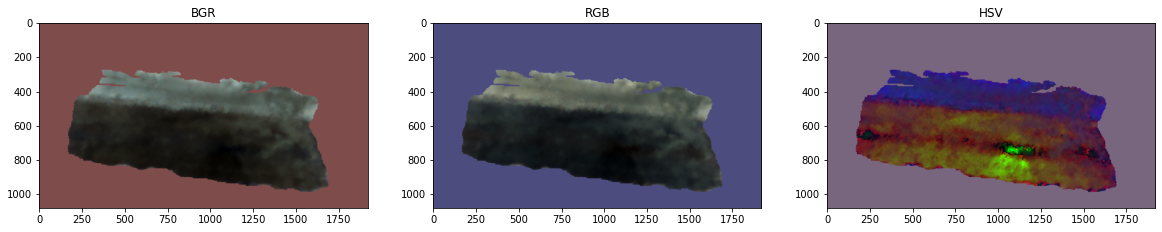

In [7]:
img_name = "RPf_00068.png"
img = cv2.imread(f"images/raw/border/{img_name}") #cv2.imread("C:\\Users\\yaniv\\Desktop\\MSCBenGurion\\Courses\\Vision - Ohad Ben Shahar\\borders_detection\\RPf_00102.png")
img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
plot_images([img,img_rgb,img_hsv],["BGR","RGB","HSV"],1,3)

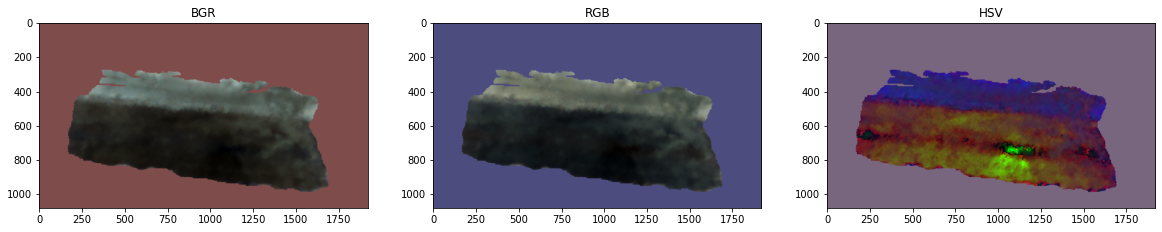

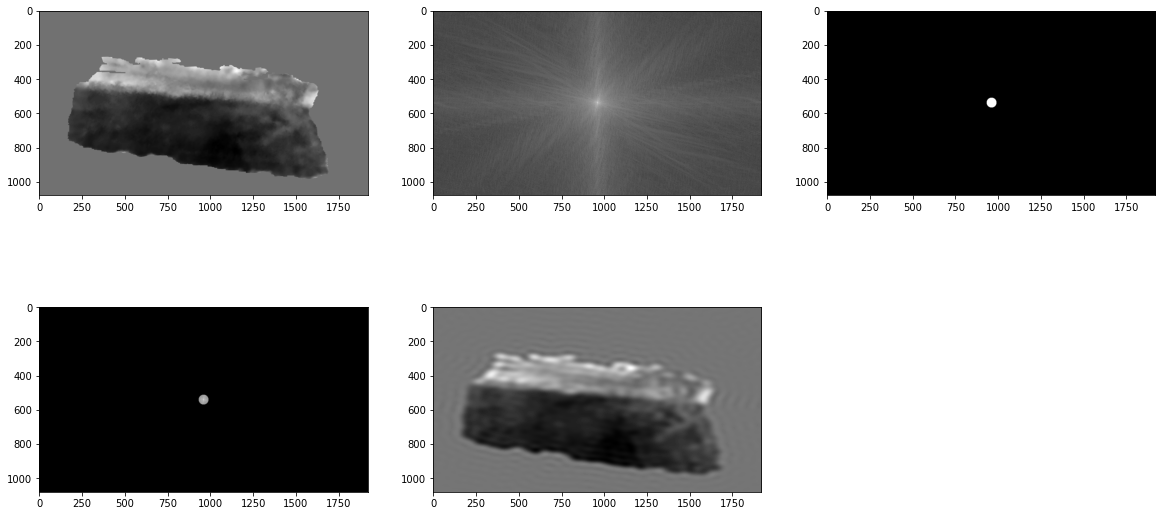

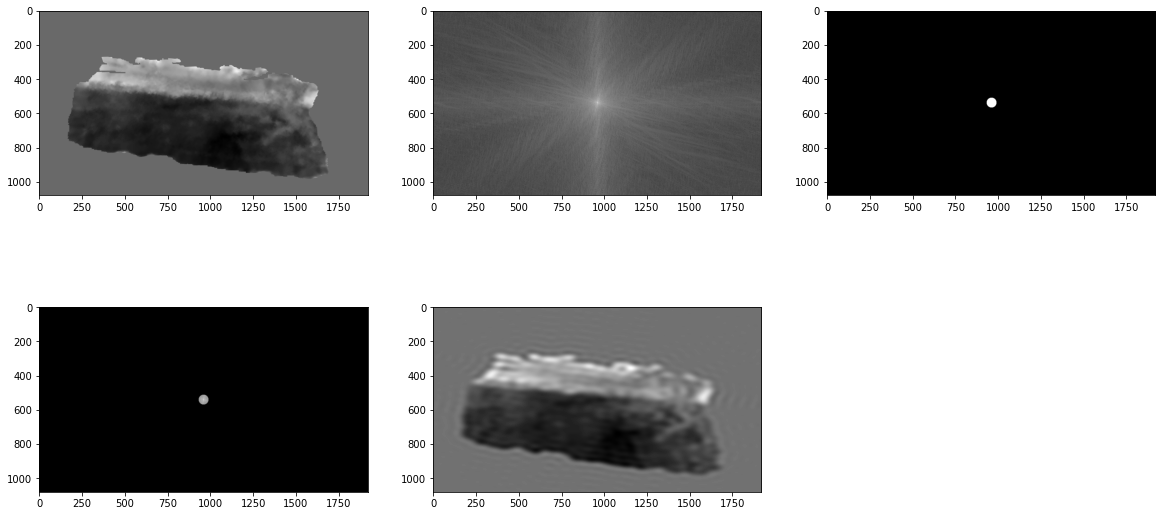

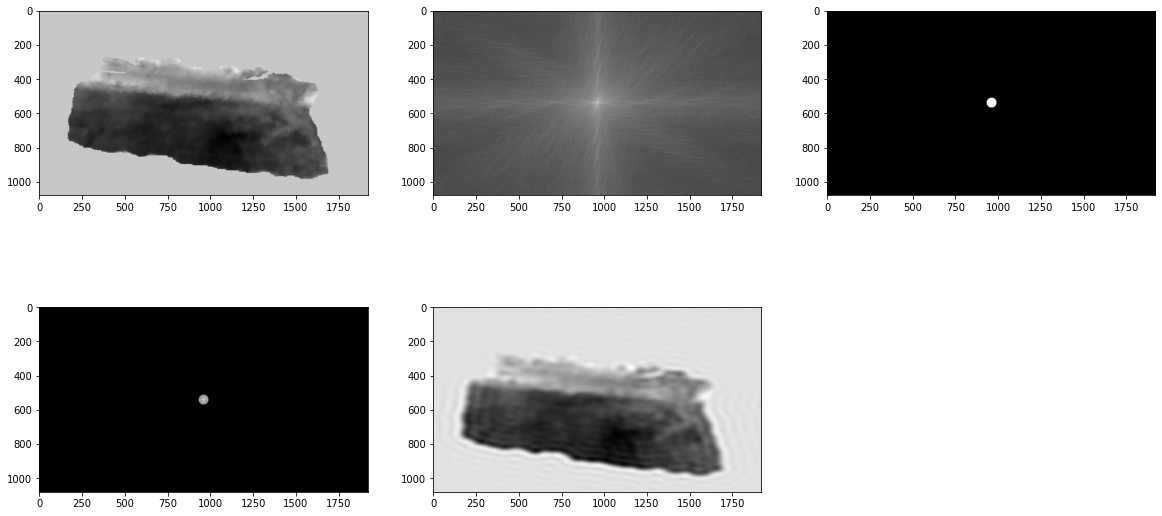

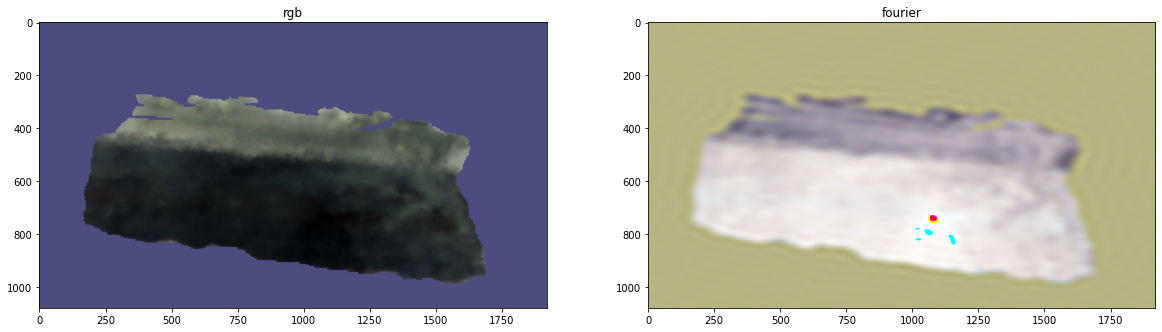

In [3]:
r,g,b = cv2.split(img_rgb)
rows,cols = r.shape
crow,ccol = rows//2,cols//2

gauss_kernel = (51,51)

fourier_img = mask_fourier([r,g,b],
                           [
                               cv2.GaussianBlur(build_circle_mask(30,ch),gauss_kernel,0)
                            for ch in [r,g,b]])


plot_images([img_rgb,(fourier_img*255).astype(np.uint8)],["rgb","fourier"],1,2)
img_rgb=(fourier_img*255).astype(np.uint8)

In [4]:
smoothed_img = cv2.bilateralFilter(img_rgb,50,200,200) #cv2.bilateralFilter(mean_smooth_rgb(img_rpf_000102_rgb,(100,100)),9,75,75)

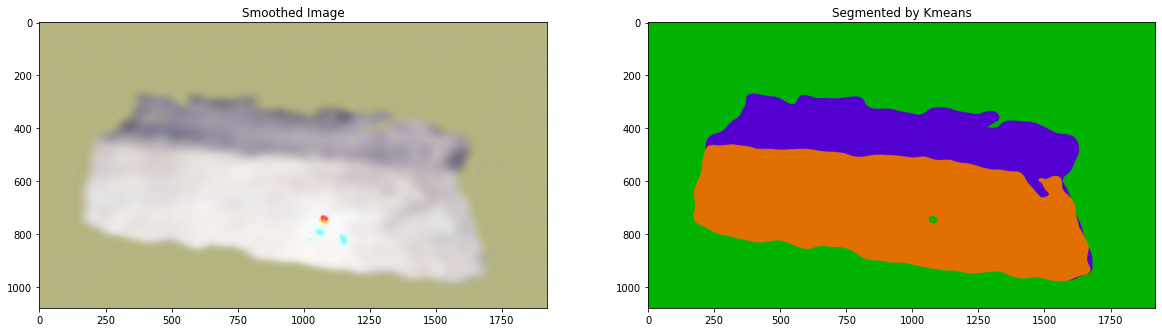

In [5]:
kmeans_img = segment_kmeans(smoothed_img,3)
plot_images([smoothed_img,(kmeans_img*255).astype(np.uint8)],["Smoothed Image","Segmented by Kmeans"],1,2)

[[439.0, 1.6406095], [453.0, 1.6231562], [415.0, 1.6755161], [751.0, 1.727876], [805.0, 1.6755161]]
[(0, 3), (0, 4), (1, 2), (1, 4), (2, 3), (2, 4), (3, 4)]


C:\Users\yaniv\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide


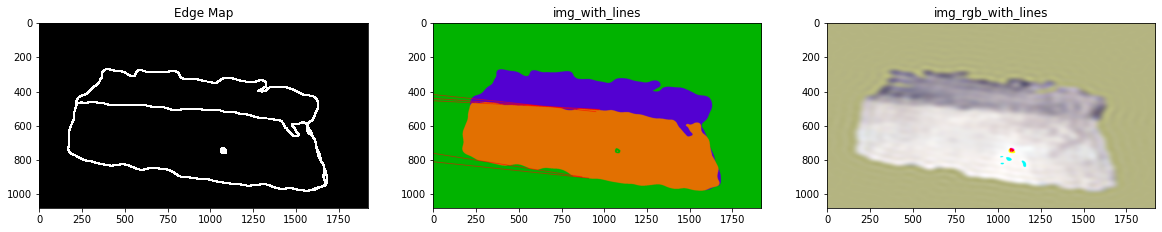

In [6]:
img_kmeans_gray = cv2.cvtColor((kmeans_img*255).astype(np.uint8),cv2.COLOR_RGB2GRAY)
img_edge_map = cv2.Canny(img_kmeans_gray,70,150)
#plt.imshow(1/(1+np.abs(img_edge_map)),cmap="gray")
#plt.imshow(1/(1+np.abs(img_edge_map)),cmap="gray")

img_with_lines,out_lines = draw_hough_lines(
        (kmeans_img*255).astype(np.uint8),
        img_edge_map, #1/(1+np.abs(rpf_000102_gray_edge_map))
        1*np.pi/180,min_votes=100,
        lines_color=(255,0,0))
#plt.imshow(img_with_lines)
print(out_lines)
max_theta_thresh = 0.1
min_r_thresh = 30
parrallel_lines = find_parallel_lines(out_lines,
                                      max_theta_thresh=max_theta_thresh,
                                      min_r_thresh=min_r_thresh)
print(parrallel_lines)

img_rgb_with_lines = np.copy(img_rgb)
lines_color=(255,0,0)
for parralel_pair in parrallel_lines:
    for ln_i in range(2):
        line_ = out_lines[parralel_pair[ln_i]]
        (x11,y11),(x12,y12) = r_theta_to_points(line_[0],line_[1])
        cv2.line(img_rgb_with_lines,(x11,y11),(x12,y12),lines_color,12)
    #second_line = parralel_pair[1]
#plt.imshow(img_rgb_with_lines)
figsize=(20,20)
fig,axes = plt.subplots(1,3,figsize=figsize)
axes[0].imshow(1/(1+np.abs(img_edge_map)),cmap="gray")
axes[0].set_title("Edge Map")
for ax,image,title in zip(axes.flatten()[1:],[img_with_lines,img_rgb_with_lines],["img_with_lines","img_rgb_with_lines"]):
    ax.imshow(image)
    ax.set_title(title)

h
h


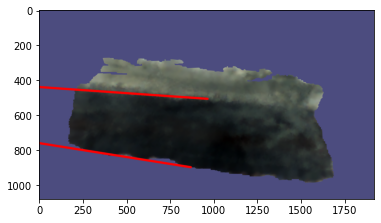

In [8]:
img_rgb_with_lines = np.copy(img_rgb)
plt.imshow(img_rgb_with_lines)

for parralel_pair in parrallel_lines[:1]:
    for ln_i in range(2):
        line_ = out_lines[parralel_pair[ln_i]]
        (x11,y11),(x12,y12) = r_theta_to_points(line_[0],line_[1])
        print("h")
        cv2.line(img_rgb_with_lines,(x11,y11),(x12,y12),lines_color,12)
        
plt.imshow(img_rgb_with_lines)

# RPf_00102

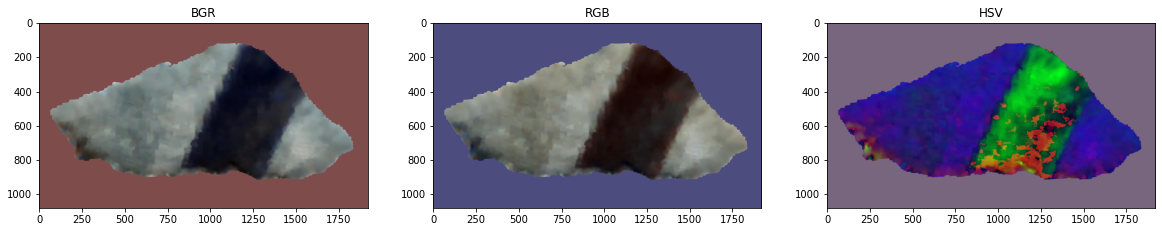

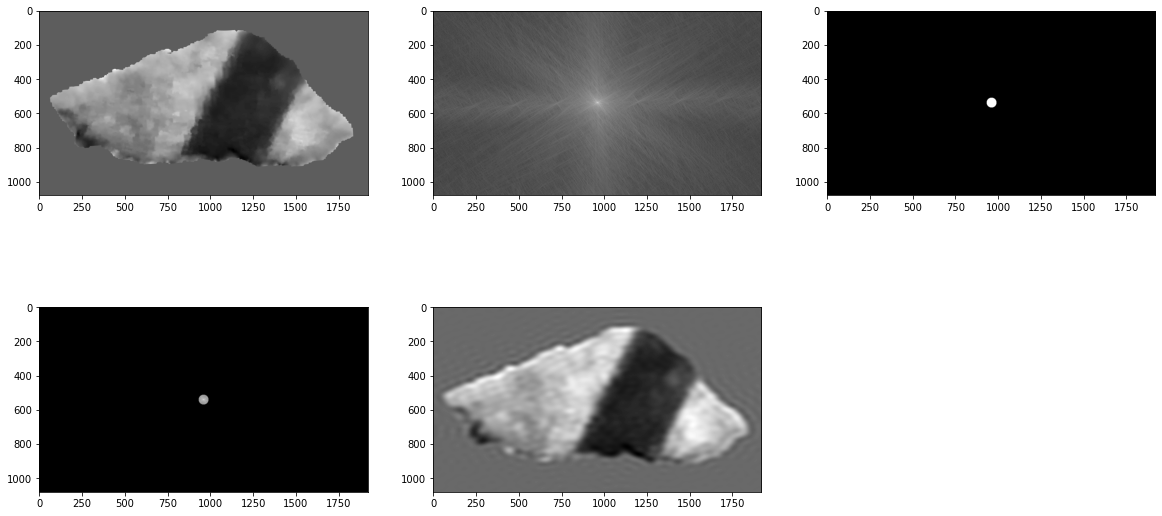

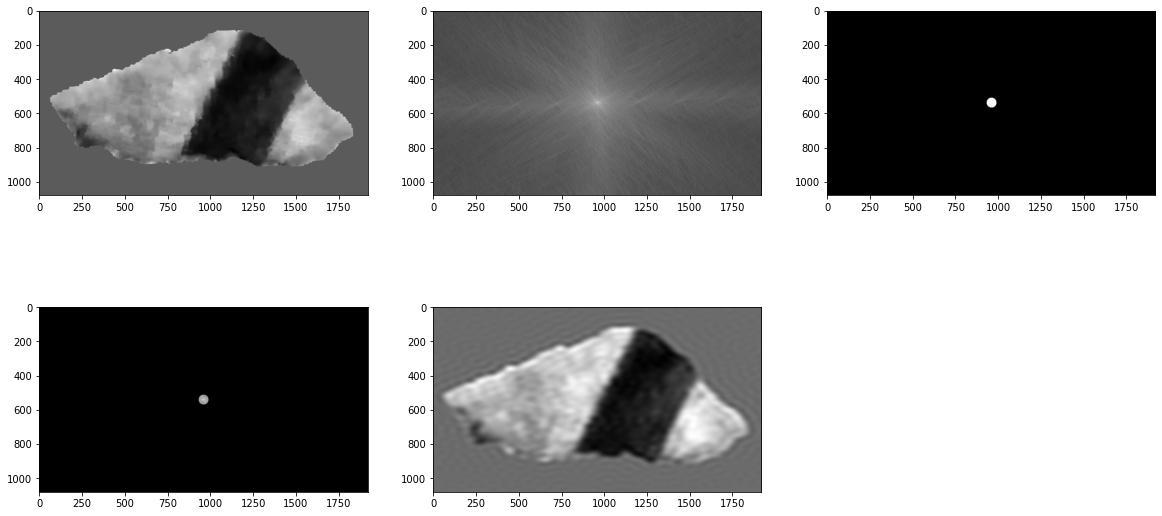

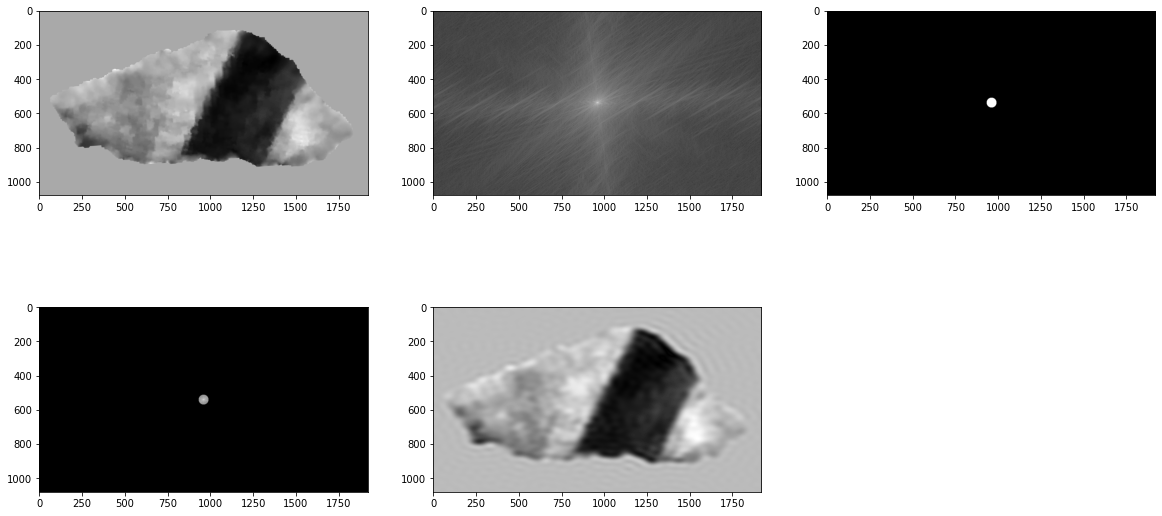

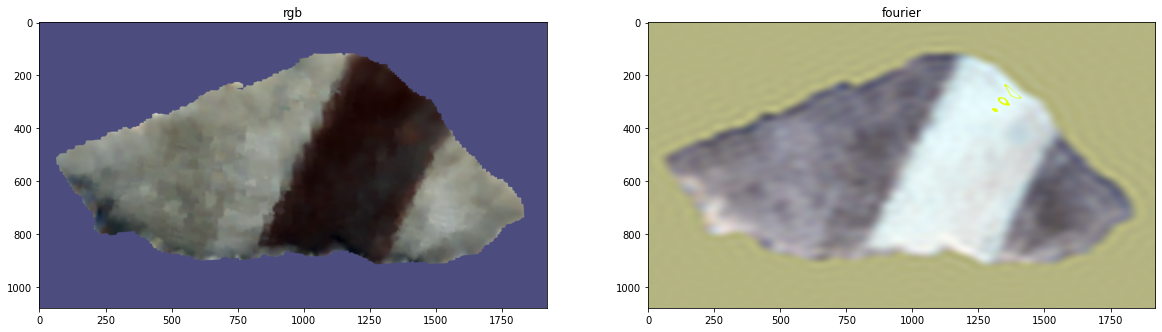

In [5]:
img_name = "RPf_00102.png"
img = cv2.imread(f"images/raw/border/done/{img_name}") #cv2.imread("C:\\Users\\yaniv\\Desktop\\MSCBenGurion\\Courses\\Vision - Ohad Ben Shahar\\borders_detection\\RPf_00102.png")
img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
plot_images([img,img_rgb,img_hsv],["BGR","RGB","HSV"],1,3)

r,g,b = cv2.split(img_rgb)
rows,cols = r.shape
crow,ccol = rows//2,cols//2

gauss_kernel = (51,51)

fourier_img = mask_fourier([r,g,b],
                           [
                               cv2.GaussianBlur(build_circle_mask(30,ch),gauss_kernel,0)
                            for ch in [r,g,b]])


plot_images([img_rgb,(fourier_img*255).astype(np.uint8)],["rgb","fourier"],1,2)
fourier_img=(fourier_img*255).astype(np.uint8)

In [6]:
smoothed_img = cv2.bilateralFilter(fourier_img,50,200,200) #cv2.bilateralFilter(mean_smooth_rgb(img_rpf_000102_rgb,(100,100)),9,75,75)

In [7]:
kmeans_img_2 = segment_kmeans(smoothed_img,6,random_state=1)
plot_images([smoothed_img,(kmeans_img_2*255).astype(np.uint8)],["Smoothed Image","Segmented by Kmeans"],1,2)

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_fast._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
kmeans_img = segment_kmeans(smoothed_img,4)
plot_images([smoothed_img,(kmeans_img*255).astype(np.uint8)],["Smoothed Image","Segmented by Kmeans"],1,2)

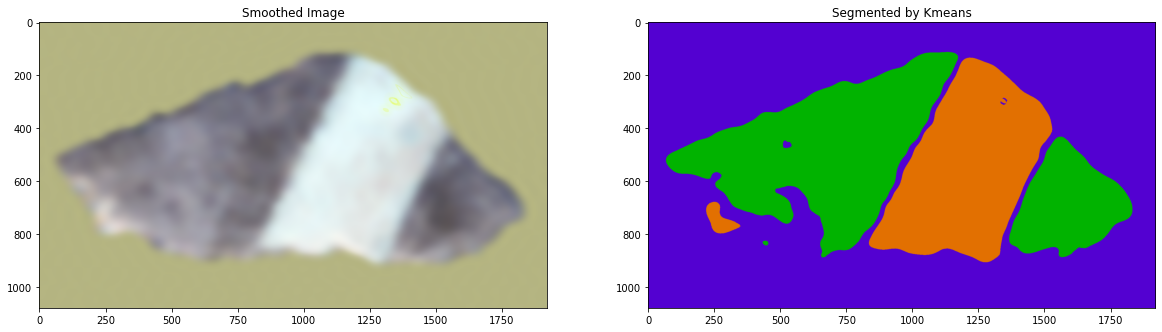

In [8]:
kmeans_img = segment_kmeans(smoothed_img,3)
plot_images([smoothed_img,(kmeans_img*255).astype(np.uint8)],["Smoothed Image","Segmented by Kmeans"],1,2)

In [9]:
algo = regionGrow(kmeans_img,0.99)
algo.run()

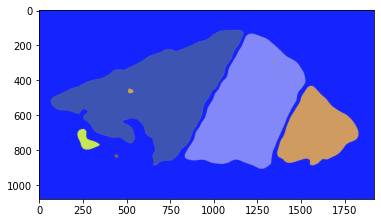

In [10]:
import random
segments_colors = np.array(
                            [
                                255 * np.array([random.uniform(0,1),random.uniform(0,1),random.uniform(0,1)])
                                for _ in range(algo.n_region+1)])
out_img = segments_colors[algo.labels.reshape(-1)]
out_img = out_img.reshape(
    algo.im.shape[0],
    algo.im.shape[1],
    algo.im.shape[2]
)
plt.imshow((out_img*255).astype(np.uint8))

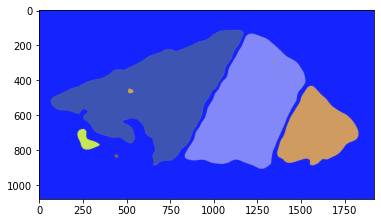

In [11]:
plt.imshow((out_img*255).astype(np.uint8))

In [12]:
kmeans_img = out_img

[[1549.0, 0.40142572], [486.0, 1.2217305], [1105.0, 0.47123888], [1114.0, 0.5061455], [1119.0, 0.4886922], [1551.0, 0.41887903], [1108.0, 0.5235988], [1125.0, 0.47123888], [1115.0, 0.43633232], [1117.0, 0.41887903], [-829.0, 2.3736477], [489.0, 1.2042772], [1121.0, 0.47123888], [488.0, 1.1693705], [477.0, 1.2391838], [-803.0, 2.3561945], [1114.0, 0.4537856], [1103.0, 0.4886922], [1112.0, 0.54105204]]
[(0, 2), (0, 4), (0, 7), (0, 8), (0, 9), (0, 12), (0, 16), (0, 17), (2, 5), (3, 5), (4, 5), (5, 7), (5, 8), (5, 9), (5, 12), (5, 16), (5, 17)]
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h
h


C:\Users\yaniv\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide


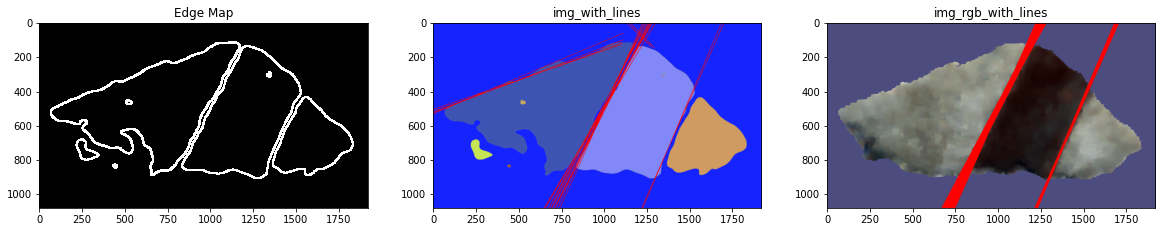

In [13]:
img_kmeans_gray = cv2.cvtColor((kmeans_img*255).astype(np.uint8),cv2.COLOR_RGB2GRAY)
img_edge_map = cv2.Canny(img_kmeans_gray,70,150)
#plt.imshow(1/(1+np.abs(img_edge_map)),cmap="gray")
#plt.imshow(1/(1+np.abs(img_edge_map)),cmap="gray")

img_with_lines,out_lines = draw_hough_lines(
        (kmeans_img*255).astype(np.uint8),
        img_edge_map, #1/(1+np.abs(rpf_000102_gray_edge_map))
        1*np.pi/180,min_votes=100,
        lines_color=(255,0,0))
#plt.imshow(img_with_lines)
print(out_lines)
max_theta_thresh = 0.1
min_r_thresh = 30
parrallel_lines = find_parallel_lines(out_lines,
                                      max_theta_thresh=max_theta_thresh,
                                      min_r_thresh=min_r_thresh)
print(parrallel_lines)

img_rgb_with_lines = np.copy(img_rgb)
lines_color=(255,0,0)
for parralel_pair in parrallel_lines[:-1]:
    
    for ln_i in range(2):
        line_ = out_lines[parralel_pair[ln_i]]
        (x11,y11),(x12,y12) = r_theta_to_points(line_[0],line_[1])
        print("h")
        cv2.line(img_rgb_with_lines,(x11,y11),(x12,y12),lines_color,12)
    #second_line = parralel_pair[1]
#plt.imshow(img_rgb_with_lines)
figsize=(20,20)
fig,axes = plt.subplots(1,3,figsize=figsize)
axes[0].imshow(1/(1+np.abs(img_edge_map)),cmap="gray")
axes[0].set_title("Edge Map")
for ax,image,title in zip(axes.flatten()[1:],[img_with_lines,img_rgb_with_lines],["img_with_lines","img_rgb_with_lines"]):
    ax.imshow(image)
    ax.set_title(title)

h
h


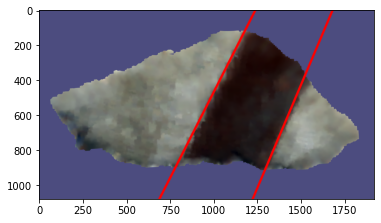

In [14]:
img_rgb_with_lines = np.copy(img_rgb)
plt.imshow(img_rgb_with_lines)

for parralel_pair in parrallel_lines[:1]:
    for ln_i in range(2):
        line_ = out_lines[parralel_pair[ln_i]]
        (x11,y11),(x12,y12) = r_theta_to_points(line_[0],line_[1])
        print("h")
        cv2.line(img_rgb_with_lines,(x11,y11),(x12,y12),lines_color,12)
        
plt.imshow(img_rgb_with_lines)

In [15]:
lines_diff = out_lines[parrallel_lines[0][0]][0] - out_lines[parrallel_lines[0][1]][0]
print(lines_diff)
borders_widths.append(lines_diff)
print(borders_widths)

444.0


NameError: name 'borders_widths' is not defined

In [16]:
algo.labels.shape

(1080, 1920)

[    1     2     3 ... 10073 10074 10075]
208


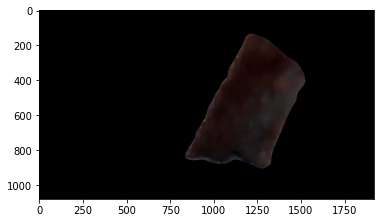

In [26]:
kmeans_labels = algo.labels#segment_kmeans_labels(smoothed_img,10)

label_ = kmeans_labels[600,1000]
print(np.unique(kmeans_labels))
print(label_)

label_ = 208

label_mask = np.where(kmeans_labels == label_, 1,0)

# r_,g_,b_ = cv2.split(img_rgb)
# r_ = np.where(r_==label_,r_,0)
# b_ = np.bitwise_and(b_,label_mask)
# g_ = np.bitwise_and(g_,label_mask)
# img_rgb_masked = cv2.merge((r_,g_,b_))

new_img = np.copy(img_rgb)#.reshape(img_rgb.shape[0]*img_rgb.shape[1], img_rgb.shape[2])


for i in range(img_rgb.shape[0]):
    for j in range(img_rgb.shape[1]):
        if label_mask[i,j] != 1:
            new_img[i,j] = (0,0,0)
plt.imshow(new_img)

In [28]:
img_as_vec = new_img.reshape(img_rgb.shape[0]*img_rgb.shape[1], img_rgb.shape[2])
zeros = np.zeros((1,3))
#img_as_vec = img_as_vec[np.all()]
new_vector = []

for i_row in range(img_as_vec.shape[0]):
    if not np.all(img_as_vec[i_row] == zeros):
        new_vector.append(img_as_vec[i_row])

mean_ = np.mean(new_vector,axis=0)
#averaged_colors.append(mean_)
print(len(new_vector))
print(mean_)

303382
[35.83957189 22.94138083 21.8867863 ]
